In [4]:
import sys
import time
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor
import random



import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import matplotlib.pyplot as plt
import seaborn as sns


Questions:
1. For Winsorazation, why professor only suggested 95% percentile upper bound, but not 5% percentile lower bound?

In [5]:
def linear_trainset_preprocessing(df):


    x_train = df.drop(columns=['PID','Longitude','Latitude','Sale_Price'], axis = 1)
    y_train = np.log(df["Sale_Price"])


    #Only "Garage_Yr_Blt" has missing values upon examination, replace the missing values with zero.
    x_train.fillna(0, inplace=True)


    # To deal with inbalance issue, remove the variables that has one value dominates with a high percentage greater than 98%.
    variables_to_remove = []
    for column in x_train:
      dominant_percentage = x_train[column].value_counts(normalize=True).max()
      if dominant_percentage > 0.98:
        variables_to_remove.append(column)

    x_train = x_train.drop(columns=variables_to_remove)

    # Calculate medians for numerical columns and use those medians to fill missing values in the test set.
    """
    numerical_columns = x_train[['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'Mas_Vnr_Area', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF',
       'Total_Bsmt_SF', 'First_Flr_SF', 'Second_Flr_SF', 'Low_Qual_Fin_SF',
       'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
       'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd',
       'Fireplaces', 'Garage_Yr_Blt', 'Garage_Cars', 'Garage_Area',
       'Wood_Deck_SF', 'Open_Porch_SF', 'Enclosed_Porch', 'Three_season_porch',
       'Screen_Porch', 'Pool_Area', 'Misc_Val', 'Mo_Sold', 'Year_Sold']]  
    """
    numerical_columns = x_train.select_dtypes(include=np.number)
    medians_dict = numerical_columns.median().to_dict()


    # For outliers in numerical variables, use winsorization to replace the highest 5% of the data by the value of the data at the 95th percentile
    #store the max values for winsorized columns and use it to clip the test data later.

    numerical_columns = ['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'Mas_Vnr_Area', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF',
       'Total_Bsmt_SF', 'First_Flr_SF', 'Second_Flr_SF', 'Low_Qual_Fin_SF',
       'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
       'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd',
       'Fireplaces', 'Garage_Yr_Blt', 'Garage_Cars', 'Garage_Area',
       'Wood_Deck_SF', 'Open_Porch_SF', 'Enclosed_Porch', 'Three_season_porch',
       'Screen_Porch', 'Pool_Area', 'Misc_Val', 'Mo_Sold', 'Year_Sold']
    numerical_columns = x_train.select_dtypes(include=['number']).columns.tolist()
    winsorized_max = {}

    for column in numerical_columns:
        x_train[column] = winsorize(x_train[column], limits=(0, 0.05))
        winsorized_max[column] = x_train[column].max()


    # Encode catogorical variables to create binary dummy variables
    columns_to_encode = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape',
       'Land_Contour', 'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl',
       'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual',
       'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional',
       'Fireplace_Qu', 'Garage_Type', 'Garage_Finish', 'Garage_Qual',
       'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence', 'Misc_Feature',
       'Sale_Type', 'Sale_Condition']
    columns_to_encode = x_train.select_dtypes(include=['object']).columns.tolist()
    encoder = OneHotEncoder(sparse_output=False,handle_unknown = "ignore")
    encoder.fit(x_train[columns_to_encode])

    x_train_encoded_data = encoder.transform(x_train[columns_to_encode])
    x_train_encoded_df = pd.DataFrame(x_train_encoded_data, columns=encoder.get_feature_names_out(input_features=columns_to_encode))
    x_train_all = pd.concat([x_train_encoded_df, x_train.drop(columns=columns_to_encode)], axis=1)



    # Create a StandardScaler instance and fit it on the training data,
    # Transform the training data using the fitted scaler and transform the test data using the same scaler

    scaler = StandardScaler()
    scaler.fit(x_train_all)
    X_train_final = scaler.transform(x_train_all)

    return X_train_final, y_train, variables_to_remove, medians_dict, winsorized_max,encoder, columns_to_encode, scaler



In [6]:
def linear_testset_preprocessing(df,variables_to_remove,medians_dict, winsorized_max, encoder, columns_to_encode, scaler):


    x_test = df.drop(columns=['PID','Longitude','Latitude'], axis = 1)
    x_test_PID = df["PID"]

    x_test = x_test.drop(columns=variables_to_remove)

    # Fill missing values in the test set using the stored medians
    for col, median in medians_dict.items():
        x_test[col].fillna(median, inplace=True)

    # Apply Winsorization to specified columns using bounds from train data
    for column, max in winsorized_max.items():
      x_test[column] = np.clip(x_test[column], 0, max)


    # Transform the test data using the same encoder of train data
    x_test_encoded = encoder.transform(x_test[columns_to_encode])
    x_test_encoded_df = pd.DataFrame(x_test_encoded, columns=encoder.get_feature_names_out(input_features=columns_to_encode))
    x_test_encoded_all = pd.concat([x_test_encoded_df, x_test.drop(columns=columns_to_encode)], axis=1)


    X_test_final = scaler.transform(x_test_encoded_all)


    return X_test_final

In [7]:
def tree_trainset_preprocessing(df):

      x_train = df.drop(columns=['PID','Sale_Price'], axis = 1)
      y_train = np.log(df["Sale_Price"])


      #Only "Garage_Yr_Blt" has missing values upon examination, replace the missing values with zero.
      x_train.fillna(0, inplace=True)


      # Calculate medians for numerical columns and use those medians to fill missing values in the test set.
      numerical_columns = ['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add', 'Mas_Vnr_Area', 
                           'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF',
                           'Total_Bsmt_SF', 'First_Flr_SF', 'Second_Flr_SF', 'Low_Qual_Fin_SF',
                           'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
                           'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd',
                           'Fireplaces', 'Garage_Yr_Blt', 'Garage_Cars', 'Garage_Area',
                           'Wood_Deck_SF', 'Open_Porch_SF', 'Enclosed_Porch', 'Three_season_porch',
                           'Screen_Porch', 'Pool_Area', 'Misc_Val', 'Mo_Sold', 'Year_Sold']    
      numerical_columns = x_train.select_dtypes(include=np.number)
      medians_dict = numerical_columns.median().to_dict()


      # Encode catogorical variables to create binary dummy variables
      columns_to_encode = ['MS_SubClass', 'MS_Zoning', 'Street', 'Alley', 'Lot_Shape',
        'Land_Contour', 'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
        'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
        'Overall_Qual', 'Overall_Cond', 'Roof_Style', 'Roof_Matl',
        'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual',
        'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
        'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC',
        'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional',
        'Fireplace_Qu', 'Garage_Type', 'Garage_Finish', 'Garage_Qual',
        'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence', 'Misc_Feature',
        'Sale_Type', 'Sale_Condition']
    
      columns_to_encode = x_train.select_dtypes(include=['object']).columns.tolist()
      encoder = OneHotEncoder(sparse_output=False,handle_unknown = "ignore")
      encoder.fit(x_train[columns_to_encode])

      x_train_encoded_data = encoder.transform(x_train[columns_to_encode])
      x_train_encoded_df = pd.DataFrame(x_train_encoded_data, columns=encoder.get_feature_names_out(input_features=columns_to_encode))
      x_train_all = pd.concat([x_train_encoded_df, x_train.drop(columns=columns_to_encode)], axis=1)


      return x_train_all, y_train, medians_dict,encoder, columns_to_encode


In [8]:
def tree_testset_preprocessing(df,medians_dict, encoder, columns_to_encode):


    x_test = df.drop(columns=['PID'], axis = 1)
    x_test_PID = df["PID"]

    # Fill missing values in the test set using the stored medians
    for col, median in medians_dict.items():
        x_test[col].fillna(median, inplace=True)


    # Transform the test data using the same encoder of train data
    x_test_encoded = encoder.transform(x_test[columns_to_encode])
    x_test_encoded_df = pd.DataFrame(x_test_encoded, columns=encoder.get_feature_names_out(input_features=columns_to_encode))
    X_test_final = pd.concat([x_test_encoded_df, x_test.drop(columns=columns_to_encode)], axis=1)

    return X_test_final

In [9]:
def lasso(X_train,X_test,Y_train,Y_test):

    lasso_alphas = np.logspace(-10, 10, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
    lassocv.fit(X_train, Y_train)


    cv_alpha = lassocv.alpha_
    print("lasso:cv_alpha=", cv_alpha )

    #### alpha_min
    lasso_model_min = Lasso(alpha = cv_alpha, max_iter=5000)
    lasso_model_min.fit(X_train, Y_train)
    lasso_rmse = mean_squared_error(Y_test, lasso_model_min.predict(X_test))

    return sqrt(lasso_rmse)

In [10]:
def ridge(X_train,X_test,Y_train,Y_test):

    alphas = np.logspace(-10, 10, 100)
    ridgecv = RidgeCV(alphas = alphas, cv = 10)
    ridgecv.fit(X_train, Y_train)


    cv_alpha = ridgecv.alpha_
    print("ridge:cv_alpha=", cv_alpha )

    #### alpha_min
    ridge_model_min = Ridge(alpha = cv_alpha)
    ridge_model_min.fit(X_train, Y_train)
    rmse = mean_squared_error(Y_test, ridge_model_min.predict(X_test))

    return sqrt(rmse)

In [11]:
def ridge_lasso(X_train,X_test,Y_train,Y_test):

    # Get best alpha via lassoCV
    lasso_alphas = np.logspace(-10, 10, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
    lassocv.fit(X_train, Y_train)

    cv_alpha = lassocv.alpha_
    print("ridge_lasso:cv_alpha=", cv_alpha )
    
    # fit lasso with best alpha
    lasso_model_min = Lasso(alpha = lassocv.alpha_, max_iter=10000)
    lasso_model_min.fit(X_train, Y_train)

    # refit ridge with lasso alpha and coefficients
    nonzero_indices = np.where(lasso_model_min.coef_ != 0)[0]
    ridge_model = Ridge(alpha = lassocv.alpha_)

    ridge_model.fit(X_train[:, nonzero_indices], Y_train)
    Ridge_mse_err = mean_squared_error(Y_test, ridge_model.predict(X_test[:, nonzero_indices]))

    return sqrt(Ridge_mse_err)


In [12]:
def ridge_lasso_v2(X_train,X_test,Y_train,Y_test):

    # Get best alpha via lassoCV
    lasso_alphas = np.logspace(-10, 10, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
    lassocv.fit(X_train, Y_train)

    cv_alpha = lassocv.alpha_
    print("ridge_lasso:cv_alpha=", cv_alpha )
    
    # fit lasso with best alpha
    lasso_model_min = Lasso(alpha = lassocv.alpha_, max_iter=10000)
    lasso_model_min.fit(X_train, Y_train)

    # refit ridge with lasso alpha and coefficients
    nonzero_indices = np.where(lasso_model_min.coef_ != 0)[0]
    X_train = X_train[:, nonzero_indices]
    X_test = X_test[:, nonzero_indices]
    
    Ridge_mse_err = ridge(X_train,X_test,Y_train,Y_test)

    return Ridge_mse_err


In [13]:
def tree_model(X_train,X_test,Y_train,Y_test):

    tree_regressor = GradientBoostingRegressor(
    learning_rate=0.02, n_estimators=1000, subsample=0.5,max_depth=6)
    tree_regressor.fit(X_train, Y_train)
    tree_mse_err = mean_squared_error(Y_test, tree_regressor.predict(X_test))

    return (sqrt(tree_mse_err), tree_regressor)


In [ ]:
%%time

if __name__ == "__main__":

    random.seed(4844)

    dataset = tqdm(range (10))
    #dataset = tqdm(np.array([2]))
    for i in dataset:
        index = i+1
        
        x_train_path = 'proj1/fold{}/train.csv'.format(index)
        x_test_path = 'proj1/fold{}/test.csv'.format(index)
        y_test_path = 'proj1/fold{}/test_y.csv'.format(index)

        x_train_set = pd.read_csv(x_train_path)
        x_test_set = pd.read_csv(x_test_path)
        y_test_set = pd.read_csv(y_test_path)
        y_test_set = np.log(y_test_set["Sale_Price"])

        start_time = time.time()

        # linear model
        X_train_final, y_train, variables_to_remove, medians_dict,winsorized_max,encoder, columns_to_encode, scaler = linear_trainset_preprocessing(x_train_set)
        X_test_final = linear_testset_preprocessing(x_test_set,variables_to_remove,medians_dict, winsorized_max, encoder, columns_to_encode, scaler)

        """
        lasso_rmse = lasso(X_train_final,X_test_final,y_train,y_test_set)

        print ("lasso_rmse for folder {}: ".format(index), lasso_rmse)
        
        ridge_lasso_rmse = ridge_lasso(X_train_final,X_test_final,y_train,y_test_set)

        print ("ridge_lasso_rmse for folder {}: ".format(index), ridge_lasso_rmse)
        """
        
        lasso_rmse = lasso(X_train_final,X_test_final,y_train,y_test_set)

        print ("lasso_rmse for folder {}: ".format(index), lasso_rmse)

        ridge_rmse = ridge(X_train_final,X_test_final,y_train,y_test_set)

        print ("ridge_rmse for folder {}: ".format(index), ridge_rmse)
        
        ridge_lasso_rmse = ridge_lasso_v2(X_train_final,X_test_final,y_train,y_test_set)

        print ("ridge_lasso_rmse for folder {}: ".format(index), ridge_lasso_rmse)
        

        # tree model
        x_train_final, y_train, medians_dict,encoder, columns_to_encode = tree_trainset_preprocessing(x_train_set)
        X_test_final = tree_testset_preprocessing(x_test_set,medians_dict, encoder, columns_to_encode)

        tree_rmse = tree_model(x_train_final,X_test_final,y_train,y_test_set)
        print ("tree_rmse for folder {}: ".format(index), tree_rmse)
        
        print("Elapsed: {} seconds".format(round(time.time() - start_time, 4)))




In [14]:
%%time

if __name__ == "__main__":

    random.seed(4844)

    dataset = tqdm(range (10))
    dataset = tqdm(np.array([1]))
    index = 1

    x_train_path = 'proj1/fold{}/train.csv'.format(index)
    x_test_path = 'proj1/fold{}/test.csv'.format(index)
    y_test_path = 'proj1/fold{}/test_y.csv'.format(index)

    x_train_set = pd.read_csv(x_train_path)
    x_test_set = pd.read_csv(x_test_path)
    y_test_set = pd.read_csv(y_test_path)
    y_test_set = np.log(y_test_set["Sale_Price"])

    start_time = time.time()

    # tree model
    x_train_final, y_train, medians_dict,encoder, columns_to_encode = tree_trainset_preprocessing(x_train_set)
    X_test_final = tree_testset_preprocessing(x_test_set,medians_dict, encoder, columns_to_encode)

    (tree_rmse, tree_model) = tree_model(x_train_final,X_test_final,y_train,y_test_set)
    print ("tree_rmse for folder {}: ".format(index), tree_rmse)

    print("Elapsed: {} seconds".format(round(time.time() - start_time, 4)))




  0%|                                                                                                                              | 0/10 [00:00<?, ?it/s]


tree_rmse for folder 1:  0.11174486965075672
Elapsed: 10.3587 seconds
CPU times: user 10.3 s, sys: 96.9 ms, total: 10.4 s
Wall time: 10.5 s


In [16]:
from sklearn import tree

print(tree_model)

#tree.plot_tree(tree_model)

tree_model.

GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=1000,
                          subsample=0.5)


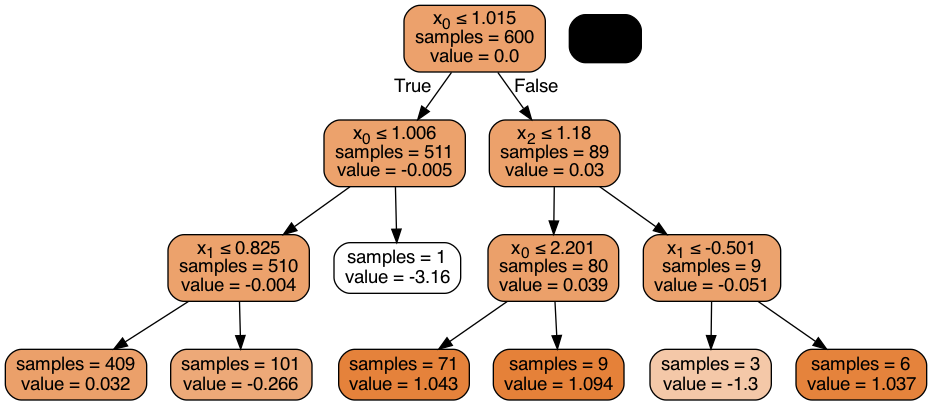

In [1]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
import numpy as np

# Ficticuous data
np.random.seed(0)
X = np.random.normal(0,1,(1000, 3))
y = X[:,0]+X[:,1]*X[:,2] > 0

# Classifier
clf = GradientBoostingClassifier(max_depth=3, random_state=0)
clf.fit(X[:600], y[:600])

# Get the tree number 42
sub_tree_42 = clf.estimators_[42, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('./out.png').write_bytes(png)
# Display
Image(png)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      random_state=RandomState(MT19937) at 0x11F221E40)


AttributeError: 'GradientBoostingRegressor' object has no attribute 'tree_'

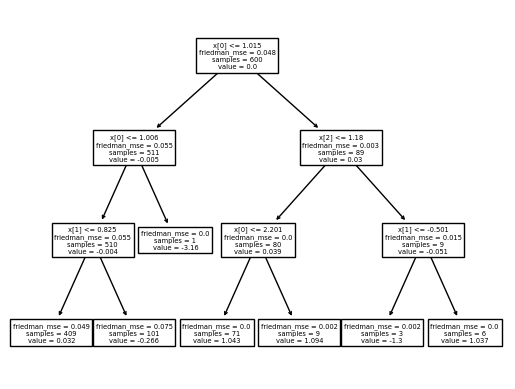

In [20]:
from sklearn import tree

print(sub_tree_42)

tree.plot_tree(sub_tree_42)

sub_tree_42.tree_
#tree_model.tree_

In [17]:
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    tree_model,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('./out.png').write_bytes(png)
# Display
Image(png)

AttributeError: 'GradientBoostingRegressor' object has no attribute 'tree_'